# Solutions

## Jupyter notebook usage

- To execute a code block (to run a cell) hit: `shift + return` or click on the `Run` button at the top.
- After execution the circle in the top-right corner is filled grey. Once execution has finished the circle will be filled white again.

## Solution 1 - ohsome API - Aggregation

Question: What is the temporal evolution of the number of hospitals in Florence since 2014?

### Request the ohsome API

In [1]:
import json

from datetime import datetime

import requests


base_url = "https://api.ohsome.org/v1"
endpoint = "/elements/count"
url = base_url + endpoint

with open("italy-florence.geojson", "r") as file:
    bpolys = json.load(file)

parameters = {
    "bpolys": json.dumps(bpolys),  # pass GeoJSON as string.
    # OR:
    # "bboxes: "11.1645,43.7034,11.3242,43.8579"
    "filter": "amenity=hospital or healthcare=hospital",
    "format": "json",
    "time": "2014-01-01/2022-01-01/P1Y",
}
headers = {
    "accept": "application/json",
    "Content-Type": "application/x-www-form-urlencoded",
}

for value in parameters.values():
    assert value != "", "Please provide values for the parameters"
    
response = requests.post(url, data=parameters, headers=headers)
response.raise_for_status()  # Raise an Exception if HTTP Status Code is not 200

print("Response:")
print(json.dumps(response.json(), indent=4))  # Pretty print response

result = response.json()["result"]

Response:
{
    "attribution": {
        "url": "https://ohsome.org/copyrights",
        "text": "\u00a9 OpenStreetMap contributors"
    },
    "apiVersion": "1.9.0",
    "result": [
        {
            "timestamp": "2014-01-01T00:00:00Z",
            "value": 46.0
        },
        {
            "timestamp": "2015-01-01T00:00:00Z",
            "value": 19.0
        },
        {
            "timestamp": "2016-01-01T00:00:00Z",
            "value": 18.0
        },
        {
            "timestamp": "2017-01-01T00:00:00Z",
            "value": 18.0
        },
        {
            "timestamp": "2018-01-01T00:00:00Z",
            "value": 25.0
        },
        {
            "timestamp": "2019-01-01T00:00:00Z",
            "value": 25.0
        },
        {
            "timestamp": "2020-01-01T00:00:00Z",
            "value": 23.0
        },
        {
            "timestamp": "2021-01-01T00:00:00Z",
            "value": 20.0
        },
        {
            "timestamp": "2022-01-01T00

### Plot the results

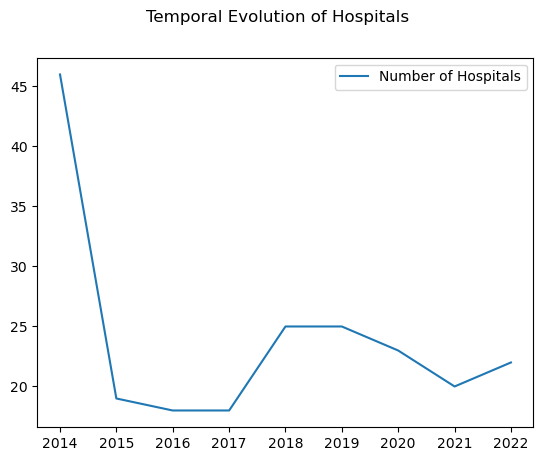

In [2]:
import matplotlib.pyplot as plt


dates = []
values = []
for r in result:
    year = datetime.fromisoformat(r["timestamp"].replace("Z", ""))
    dates.append(year)
    values.append(r["value"])

fig, ax = plt.subplots()
ax.plot(dates, values, label="Number of Hospitals")
ax.legend()
fig.suptitle("Temporal Evolution of Hospitals")
plt.show()

## Solution 2 - ohsome API - Data extraction

Question: Where are schools mapped over the years?

Goal: Get and visualize the state of schools in OSM on a yearly basis since 2014.

### Request the ohsome API

In [4]:
import json

import requests


base_url = "https://api.ohsome.org/v1"
endpoint = "/elements/centroid"
url = base_url + endpoint

with open("italy-florence.geojson", "r") as file:
    bpolys = json.load(file)

parameters = {
    "bpolys": json.dumps(bpolys),
    "filter": "amenity=school",
    "time": "2014-01-01/2022-01-01/P1Y",
}
headers = {
    "accept": "application/json",
    "Content-Type": "application/x-www-form-urlencoded",
}

for value in parameters.values():
    assert value != "", "Please provide values for the parameters"

response = requests.post(url, data=parameters, headers=headers)
response.raise_for_status()  # Raise an Exception if HTTP Status Code is not 200

feature_collection = response.json()

### Display on a map

In [5]:
import folium

from folium.plugins import TimestampedGeoJson


m = folium.Map()
m.fit_bounds([(43.7034, 11.1645), ( 43.8579, 11.3242,)])

# Add admin boundary to map
with open("italy-florence.geojson", "r") as file:
    admin_boundary = json.load(file)
folium.GeoJson(admin_boundary, name="Admin Boundary").add_to(m)

# Rename property "time"
feature_collection = response.json()
for feature in feature_collection["features"]:
    feature["properties"]["time"] = feature["properties"].pop("@snapshotTimestamp")
    
# Add centroids to map
TimestampedGeoJson(feature_collection, period="P1Y").add_to(m)
m.save("index.html")

# Show map
m

## Solution 3 - OQT API - Data Quality

OQT provides quality estimations of OpenStreetMap (OSM) data.
OQT calls those estimations Indicators.
Indicators are computed for a specific area and a certain set of aggregated OSM features called Layer. Basically a layer defines the request to the ohsome API.

Two intrinsic quality estimation OQT offers are the Mapping Saturation indicator and the Currentness indicator.

### Request the Mapping Saturation Indicator from the OQT API

The Mapping Saturation indicator calculate the saturation of mapping activity within the last 3 years.
It is based on the premise that each aggregation of features (e.g. length of roads or count of buildings) has a maximum. After increased mapping activity saturation is reached near this maximum.
The Mapping Saturation indicator works well with following layers:

- Building Count (`building_count`)
- Major Roads Length (`major_roads_length`)
- Amenities (`amenities`)
- Point-of-Interests (`poi`)

#### Task

Choose a layer you find interesting and request the Mapping Saturation Indicator from the OQT API.

Property keys: 
dict_keys(['metadata', 'layer', 'result', 'osm_id', 'boundary', 'admin_level', 'parents', 'name', 'local_name', 'name_en'])

Result: 
{
    "description": "The saturation of the last 3 years is 100.0%.\nHigh saturation has been reached (97% < Saturation \u2264 100%).\n",
    "timestamp_oqt": "2023-04-26T15:36:50.039264+00:00",
    "timestamp_osm": "2023-04-01T00:00:00+00:00",
    "value": 1.0,
    "label": "green",
    "class": 5
}


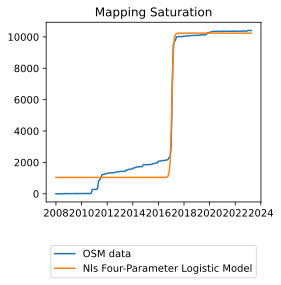

In [8]:
import json

import requests
from IPython.display import SVG, display


base_url = "https://oqt.ohsome.org/api"
endpoint = "/indicator"
url = base_url + endpoint

# OQT size restriction on the input geometry is 100 sqkm
with open("italy-florence-quartier-5.geojson", "r") as file:
    bpolys = json.load(file)

parameters = {
    "name": "MappingSaturation",
    "layerKey": "building_count",
    "bpolys": bpolys,
    "flatten": False,
    "includeSvg": True,
}

for value in parameters.values():
    assert value != "", "Please provide values for the parameters"

response = requests.post(url, json=parameters)
response.raise_for_status()  # Raise an Exception if HTTP Status Code is not 200

properties = response.json()["properties"]
result = properties["result"]
svg = result.pop("svg")

print("Property keys: ")
print(properties.keys())
print("")
print("Result: ")
print(json.dumps(result, indent=4))  # Pretty print response

display(SVG(svg))

### Request the Currentness Indicator from the OQT AP

The Currentness indicator works well with following layers:

- Building Count (`building_count`)
- Major Roads Count (`major_roads_count`)
- Amenities (`amenities`)

#### Task

Choose a layer you find interesting and request the Mapping Saturation Indicator from the OQT API.


Result: 
{
    "description": "In the last 3 years 10.39 % of the elements were edited the last time.\nIn the period from 4 to 7 years ago 75.45 % of the elements were edited the last time.\nThe remaining 14.16 % were last edited more than 8 years ago.\nThe median currentness of the 11125 features (Building Count) is 6 year(s).\nIt is likely that some features are up-to-date and some features are outdated.\n",
    "timestamp_oqt": "2023-04-26T15:36:50.039264+00:00",
    "timestamp_osm": "2023-04-23T20:00:00+00:00",
    "value": 6,
    "label": "yellow",
    "class": 2
}


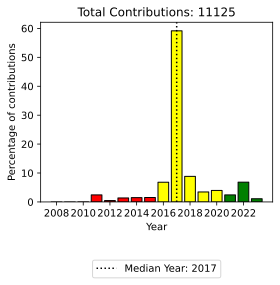

In [9]:
import json

import requests
from IPython.display import SVG, display


base_url = "https://oqt.ohsome.org/api"
endpoint = "/indicator"
url = base_url + endpoint

with open("italy-florence-quartier-5.geojson", "r") as file:
    bpolys = json.load(file)

parameters = {
    "name": "Currentness",
    "layerKey": "building_count",
    "bpolys": bpolys,
    "flatten": False,
    "includeSvg": True,
}

for value in parameters.values():
    assert value != "", "Please provide values for the parameters"

response = requests.post(url, json=parameters)
response.raise_for_status()  # Raise an Exception if HTTP Status Code is not 200

properties = response.json()["properties"]
result = properties["result"]
svg = result.pop("svg")

print("")
print("Result: ")
print(json.dumps(result, indent=4))  # Pretty print response

display(SVG(svg))